# References

In [1]:
# References

# week11 - Demo_async (functional vs sequential API)
# week06 - FFNN_DiabeticRetinopathy (building a FFNN)
# week05 - imbalanced_data (standardization)
# week03 - linear_regression (keras linear regression model)

# Import packages and data

In [1]:
# Standard
import pandas as pd
import numpy as np
import random
import os
import math

# TF and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import metrics
from keras import losses

# Plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# Silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setting random seeds
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

2023-12-02 16:58:39.600827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Google Data Import
Run to access your drive from google colab

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

X_train = pd.read_csv('drive/MyDrive/data/X_train.csv')
Y_train = pd.read_csv('drive/MyDrive/data/Y_train.csv')
X_val = pd.read_csv('drive/MyDrive/data/X_val.csv')
Y_val = pd.read_csv('drive/MyDrive/data/Y_val.csv')

## Local Data Import

In [2]:
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_val = pd.read_csv('X_val.csv')
Y_val = pd.read_csv('Y_val.csv')

In [3]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)

## Making One-Hot Encodings and Tensors for Categorical Variables

In [4]:
# Data prep

# Merging train and val into one DF to perform the encodings
X = pd.concat([X_train, X_val])

# Making the numerical categorical variables into strings - necessary to make the one-hot encodings
X[['opp_diff_ind', 'GW','was_home']] = X[['opp_diff_ind', 'GW','was_home']].astype(str)

In [5]:
# Making categorical variables into sparse one-hot encodings

season_tf = tf.keras.layers.StringLookup(vocabulary=X.season.unique(), output_mode='one_hot')(X.season)

player_team_name_tf = tf.keras.layers.StringLookup(vocabulary=X.player_team_name.unique(), 
                                                         output_mode='one_hot')(X.player_team_name)

opp_team_name_tf = tf.keras.layers.StringLookup(vocabulary=X.opp_team_name.unique(), 
                                                      output_mode='one_hot')(X.opp_team_name)

opp_diff_ind_tf = tf.keras.layers.StringLookup(vocabulary=X.opp_diff_ind.unique(), 
                                                      output_mode='one_hot')(X.opp_diff_ind)

position_tf = tf.keras.layers.StringLookup(vocabulary=X.position.unique(), output_mode='one_hot')(X.position)

gw_tf = tf.keras.layers.StringLookup(vocabulary=X.GW.unique(), output_mode='one_hot')(X.GW)

was_home_tf = tf.keras.layers.StringLookup(vocabulary=X.was_home.unique(), output_mode='one_hot')(X.was_home)

In [6]:
# Making a tensor with the split sizes
split_one = X_train.shape[0]
split_two = X_val.shape[0]

# Splitting the encoded tensors into train and test
season_train, season_val = tf.split(season_tf, [split_one, split_two], 0)

player_team_name_train, player_team_name_val = tf.split(player_team_name_tf, [split_one, split_two], 0)

opp_team_name_train, opp_team_name_val = tf.split(opp_team_name_tf, [split_one, split_two], 0)

opp_diff_ind_train, opp_diff_ind_val = tf.split(opp_diff_ind_tf, [split_one, split_two], 0)

position_train, position_val = tf.split(position_tf, [split_one, split_two], 0)

gw_train, gw_val = tf.split(gw_tf, [split_one, split_two], 0)

was_home_train, was_home_val = tf.split(was_home_tf, [split_one, split_two], 0)

In [7]:
# Making lists of train and test categorical tensors to combine

train_cat_tf = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                position_train, gw_train, was_home_train]

val_cat_tf = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
              position_val, gw_val, was_home_val]

## Prepping tensors for continuous variables

In [8]:
# Preparing column combination possibilities
all_cols = X_train.columns

lag_1 = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1',
       'creativity_lag_1', 'goals_conceded_lag_1', 'goals_scored_lag_1',
       'ict_index_lag_1', 'influence_lag_1', 'minutes_lag_1',
       'own_goals_lag_1', 'penalties_missed_lag_1', 'penalties_saved_lag_1',
       'red_cards_lag_1', 'saves_lag_1', 'selected_lag_1',
       'player_team_score_lag_1', 'opp_team_score_lag_1', 'threat_lag_1',
       'total_points_lag_1', 'value_lag_1', 'yellow_cards_lag_1']

lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

lag_5 = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
       'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
       'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
       'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
       'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
       'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
       'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']

In [9]:
# Making continuous variable tensors
X_train_contin1_tf = tf.convert_to_tensor(X_train[lag_1])
X_train_contin3_tf = tf.convert_to_tensor(X_train[lag_3])
X_train_contin5_tf = tf.convert_to_tensor(X_train[lag_5])

X_val_contin1_tf = tf.convert_to_tensor(X_val[lag_1])
X_val_contin3_tf = tf.convert_to_tensor(X_val[lag_3])
X_val_contin5_tf = tf.convert_to_tensor(X_val[lag_5])

In [10]:
# Making label tensors
Y_train_tf = tf.convert_to_tensor(Y_train)
Y_val_tf = tf.convert_to_tensor(Y_val)

# Making a linear regression model

In [25]:
# Specifying the inputs

epoch_count = 20

# Preparing the train and val tensors. I'll be using all the categorical variables and the lag 3 continuous variables for now
train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                position_train, gw_train, was_home_train, X_train_contin3_tf]

val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
              position_val, gw_val, was_home_val, X_val_contin3_tf]

X_train_input = tf.keras.layers.Concatenate(axis=1)(train_list)
X_val_input = tf.keras.layers.Concatenate(axis=1)(val_list)

num_features = X_train_input.shape[1]

In [26]:
# Building and compiling the model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

# Create input layer
model.add(tf.keras.Input(shape=(num_features,), name='Input'
          ))

# Create output layer
model.add(tf.keras.layers.Dense(
          activation = None,    # linear activation is used
          units = 1,            # output dim - need to make sure this is correct
          use_bias = True             
          ))

# Select optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=losses.MeanSquaredError(),
    metrics=[metrics.mse,
             metrics.RootMeanSquaredError(),
             metrics.mae]
    )

In [27]:
# Fitting the model
history = model.fit(
    x = X_train_input,
    y = Y_train_tf,
    epochs = epoch_count,
    validation_data = (X_val_input, Y_val_tf)
    )

Epoch 1/20
2150/2150 [==============================] - 2s 722us/step - loss: 5.0111 - mean_squared_error: 5.0111 - root_mean_squared_error: 2.2386 - mean_absolute_error: 1.2893 - val_loss: 4.5330 - val_mean_squared_error: 4.5330 - val_root_mean_squared_error: 2.1291 - val_mean_absolute_error: 1.1452
Epoch 2/20
2150/2150 [==============================] - 2s 753us/step - loss: 4.6646 - mean_squared_error: 4.6646 - root_mean_squared_error: 2.1598 - mean_absolute_error: 1.2669 - val_loss: 4.5275 - val_mean_squared_error: 4.5275 - val_root_mean_squared_error: 2.1278 - val_mean_absolute_error: 1.1223
Epoch 3/20
2150/2150 [==============================] - 2s 775us/step - loss: 4.6436 - mean_squared_error: 4.6436 - root_mean_squared_error: 2.1549 - mean_absolute_error: 1.2604 - val_loss: 4.5074 - val_mean_squared_error: 4.5074 - val_root_mean_squared_error: 2.1231 - val_mean_absolute_error: 1.1288
Epoch 4/20
2150/2150 [==============================] - 2s 751us/step - loss: 4.6343 - mean_sq

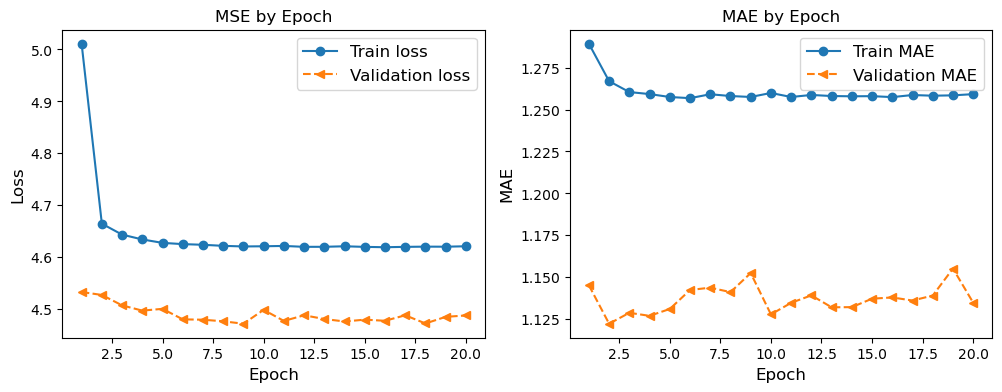

In [28]:
# Plotting loss and accuracy for training and validation sets
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.set_title('MSE by Epoch')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['mean_absolute_error'], '-o', label='Train MAE')
ax.plot(x_arr, hist['val_mean_absolute_error'], '--<', label='Validation MAE')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('MAE', size=12)
ax.set_title('MAE by Epoch')

pass

# Making a Baseline

In [18]:
# Setting up necessary functions

# Making a vector of predictions as long as the actuals
def pred_vect(true_values, prediction=2):
    predictions = []
    count = 0
    pred = prediction # Can pass baseline or 2
    while count < len(true_values):
        predictions.append(pred)
        count += 1
        
    return predictions

# Defining an MSE function
def MSE(true_values, predicted_values):
    """Return the MSE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += (true_values[count] - predicted_values[count])**2
        count += 1
    
    # Returning the MSE
    return tot / len(true_values)

def RMSE(true_values, predicted_values):
    """Return the RMSE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += (true_values[count] - predicted_values[count])**2
        count += 1
    
    # Returning the MSE
    return math.sqrt(tot / len(true_values))

def MAE(true_values, predicted_values):
    """Return the MAE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += abs(true_values[count] - predicted_values[count])
        count += 1
    
    # Returning the MSE
    return tot / len(true_values)

In [19]:
# Creating a baseline with the average value
baseline = Y_train['total_points'].mean()
baseline

1.3593784070590629

In [20]:
true = np.array(Y_train['total_points'])
pred = np.array(pred_vect(Y_train['total_points'],1))

#print(f'RMSE is {round(RMSE(true, pred),3)}')
print(f'MSE is {round(MSE(true, pred),3)}')
print(f'MAE is {round(MAE(true, pred),3)}')

MSE is 6.432
MAE is 1.508


# Making a FFNN

In [21]:
def loss_mae_plots(history):
    '''
    Takes in history from model fitting and plots loss and MAE by epoch for both train and val
    '''
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Loss', size=12)
    ax.set_title('Loss by Epoch')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['mean_absolute_error'], '-o', label='Train MAE')
    ax.plot(x_arr, hist['val_mean_absolute_error'], '--<', label='Validation MAE')
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('MAE', size=12)
    ax.set_title('MAE by Epoch')

In [52]:
# Making a DF in which to store results
results = pd.DataFrame(columns=['contin_vars', 'lagged_vars', 'learning_rate', 'epoch_count', 'hidden_layer_count',
                                'hidden_layer_size_s','hl_act_func','oput_act_func','optimizer',
                                'train_loss', 'train_mae','val_loss','val_mae'])

In [41]:
# Setup for testing different configurations

def create_nn(contin_vars='yes', lagged_vars=3, learning_rate=0.01, epoch_count=5, hidden_layer_sizes=[], 
              hl_act_func='relu', oput_act_func=None, optimizer='Adam', plot_flag=True,
              verbosity_flag=True):
    
    ############################################################################################## 1
    # Preparing the data

    # Note: the user must at least either feed in 'yes' to contin_vars or 1, 3, or 5 to lagged_vars to avoid errors;
    # if a user passed 'no' and another number, the code will error out
    
    # Runs if user wants to include continuous variables
    if contin_vars == 'yes':
        train_list = train_cat_tf
        val_list = val_cat_tf

        if lagged_vars == 1:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin1_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin1_tf]
        elif lagged_vars == 3:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin3_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin3_tf]
        elif lagged_vars == 5:
            train_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                          position_train, gw_train, was_home_train, X_train_contin5_tf]
            val_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                        position_val, gw_val, was_home_val, X_val_contin5_tf]
        else:
            pass # Should do nothing
    
        X_train_input = tf.keras.layers.Concatenate(axis=1)(train_list)
        X_val_input = tf.keras.layers.Concatenate(axis=1)(val_list)

    # Runs if user does not want to include continuous variables
    elif contin_vars == 'no':
        if lagged_vars == 1:
            X_train_input = X_train_contin1_tf
            X_val_input = X_val_contin1_tf
        elif lagged_vars == 3:
            X_train_input = X_train_contin3_tf
            X_val_input = X_val_contin3_tf
        elif lagged_vars == 5:
            X_train_input = X_train_contin5_tf
            X_val_input = X_val_contin5_tf
        else:
            raise 'Unsupported lagged_var input: %s' %lagged_vars
    
    # Getting number of features
    num_features = X_train_input.shape[1]

    ############################################################################################## 2
    # Building the model
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))

    # (Optional) Create hidden layers
    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                     activation=hl_act_func,
                                     name = f'Hidden_{i+1}'))

    # (Optional) Create dropout
    model.add(tf.keras.layers.Dropout(rate=0.3, name='Dropout') # Need to make dropout rate variable
              )
    
    # Create output layer
    model.add(tf.keras.layers.Dense(
              activation = oput_act_func,    # linear activation is used
              units = 1,                # output dim - need to make sure this is correct
              use_bias = True             
              ))
    
    # Select optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_input,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_input, Y_val_tf),
        verbose=verbosity_flag
    )

    ############################################################################################## 5
    # Displaying learning rates
    if plot_flag == True:
        loss_mae_plots(history)

    ############################################################################################## 6
    # Appending results to the results DF

    # Pulling this in to get loss and accuracy
    hist = history.history
    
    new_row = {'contin_vars': contin_vars, 'lagged_vars': lagged_vars, 'learning_rate': learning_rate, 
               'epoch_count': epoch_count, 'hidden_layer_count': len(hidden_layer_sizes), 'hidden_layer_size_s': hidden_layer_sizes,
               'hl_act_func': hl_act_func,'oput_act_func': oput_act_func,'optimizer': optimizer, 'train_loss': hist['loss'][-1], 
               'train_mae': hist['mean_absolute_error'][-1], 'val_loss': hist['val_loss'][-1], 
               'val_mae': hist['val_mean_absolute_error'][-1]}
    
    results.loc[len(results)] = new_row

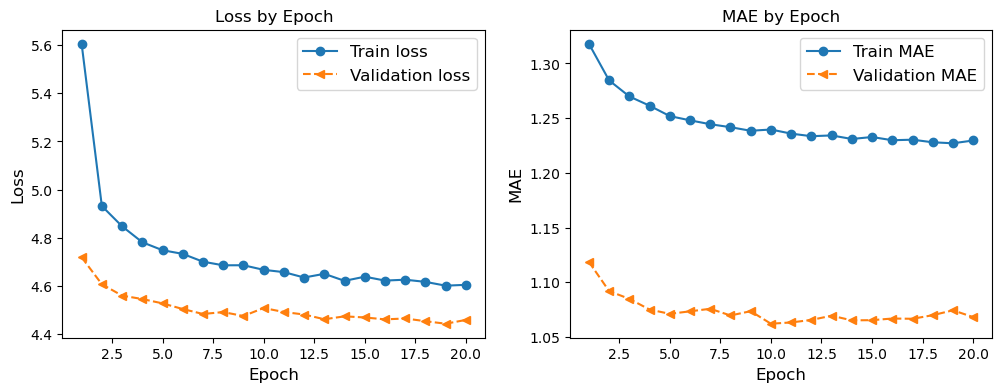

In [44]:
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=20, learning_rate=0.0001, hidden_layer_sizes=[37], verbosity_flag=False)

## Testing multiple NN builds

In [54]:
# Testing various NN configurations

for contin_vars in ['yes', 'no']: # Determines whether or not continuous variables are included
    for lagged_vars in [3]: # Determines which lagging (if any) to use - just using 3 for now
        for rate in [0.0001, 0.001]: # Learning rate(s)
            for count in [10, 20]: # Epoch count
                for hl in [[], [37],[50]]: # Hidden layer size(s) - should be a list of list(s)
                    for act_func in ['tanh','relu']: # Activation function - for both hidden layers and output layer (for now)
                        for opt in ['Adam','SGD']: # Optimizer
                            create_nn(contin_vars=contin_vars, lagged_vars=lagged_vars, learning_rate=rate, epoch_count=count, 
                                      hidden_layer_sizes=hl, hl_act_func=act_func, oput_act_func=act_func, optimizer=opt, 
                                      plot_flag=False, verbosity_flag=False)

In [55]:
# Exporting results to CSV
results.to_csv('12_2_v2_results.csv', encoding='utf-8')

In [ ]:
# Number and size of hidden layers

# Between 73 and 1
# Less than twice the size of the input layer
# 2/3 (73) + 1 = 50
# Mean of input and output layers - 37

In [56]:
# Displaying and sorting through results
results.sort_values(by='train_loss',ascending=True)

,contin_vars,lagged_vars,learning_rate,epoch_count,hidden_layer_count,hidden_layer_size_s,hl_act_func,oput_act_func,optimizer,train_loss,train_mae,val_loss,val_mae
46,yes,3,0.0010,20,1,[50],relu,relu,Adam,4.301969,1.123700,4.549056,1.062028
42,yes,3,0.0010,20,1,[37],relu,relu,Adam,4.397158,1.135906,4.482254,1.056553
34,yes,3,0.0010,10,1,[50],relu,relu,Adam,4.467166,1.160152,4.458365,1.041922
30,yes,3,0.0010,10,1,[37],relu,relu,Adam,4.493483,1.165738,4.445357,1.032241
22,yes,3,0.0001,20,1,[50],relu,relu,Adam,4.563469,1.194293,4.386528,1.109876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,no,3,0.0001,10,0,[],tanh,tanh,Adam,6.252242,1.267404,5.801263,1.191095
13,yes,3,0.0001,20,0,[],tanh,tanh,SGD,6.255208,1.307607,5.821039,1.125132
1,yes,3,0.0001,10,0,[],tanh,tanh,SGD,6.268654,1.303424,5.808955,1.154204
53,no,3,0.0001,10,1,[37],tanh,tanh,SGD,6.272772,1.284429,5.794054,1.191410


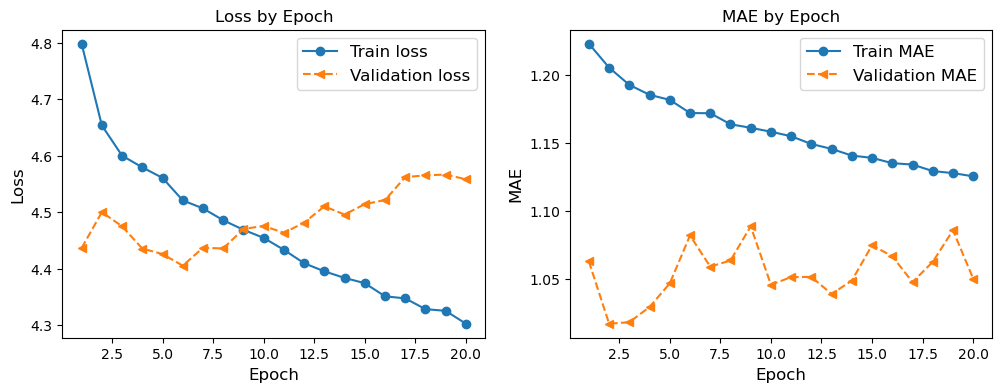

In [58]:
# Looking at learing curves for potential candidates
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=20, learning_rate=0.001, hidden_layer_sizes=[50], 
          oput_act_func = 'relu', verbosity_flag=False)

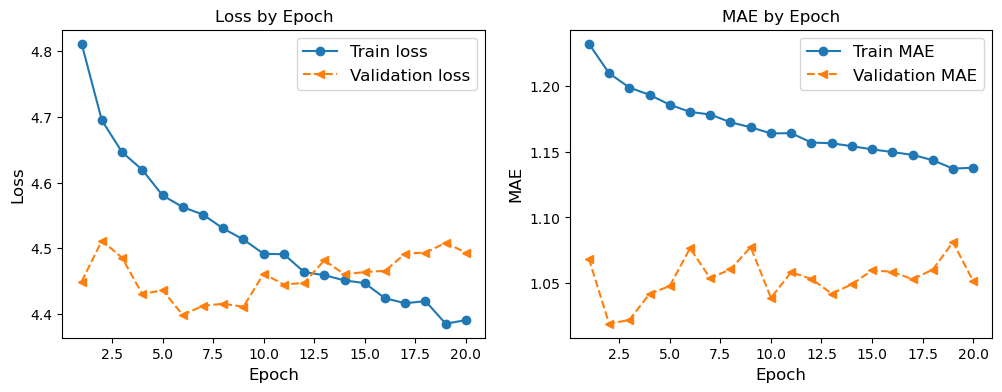

In [59]:
# Looking at learing curves for potential candidates
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=20, learning_rate=0.001, hidden_layer_sizes=[37], 
          oput_act_func = 'relu', verbosity_flag=False)

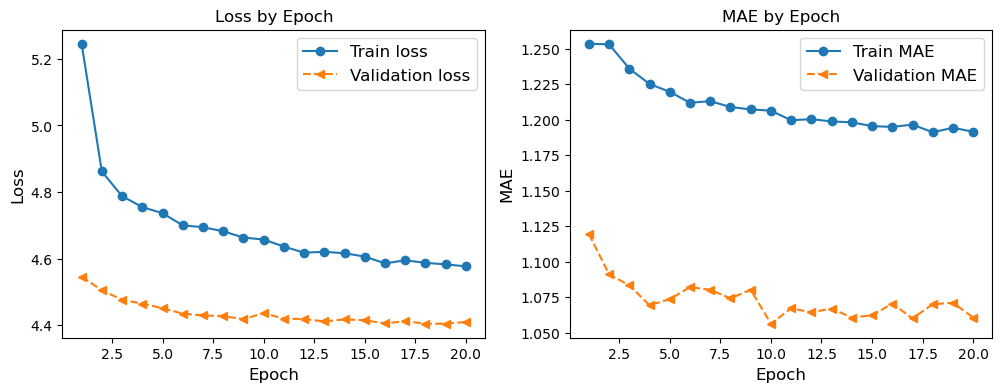

In [60]:
# Looking at learing curves for potential candidates
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=20, learning_rate=0.0001, hidden_layer_sizes=[50], 
          oput_act_func = 'relu', verbosity_flag=False)

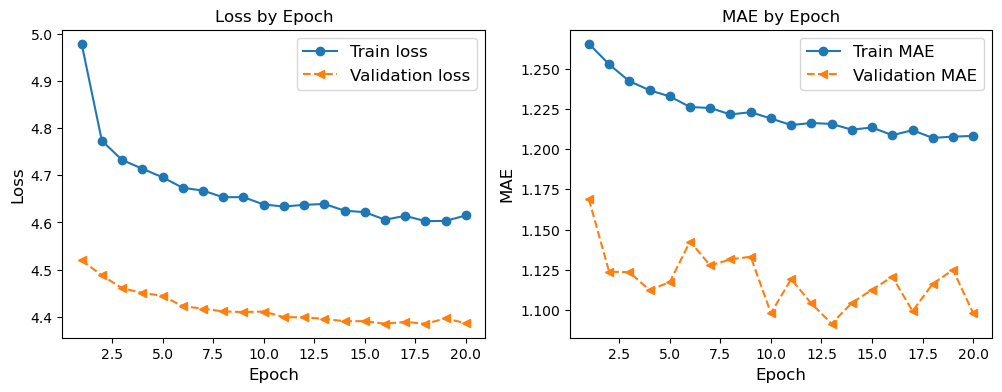

In [63]:
# Looking at learing curves for potential candidates
create_nn(contin_vars='yes', lagged_vars=3, epoch_count=20, learning_rate=0.001, hidden_layer_sizes=[50], 
          oput_act_func = 'relu', optimizer='SGD', verbosity_flag=False)

In [ ]:
# Things to try

# Minutes only
# Testing multiple learning rates to see what works
# Adding dropout of varying degrees (only changing this, possibly with higher learning rate))
# Limiting columns I'm using - might be worth going low and adding up